# Primer library generation for deep mutational scanning

In [47]:
import os
import re

from importlib import reload
from itertools import compress

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# BioPython imports
import Bio
from Bio.Seq import Seq
from Bio.Data import CodonTable
from Bio.SeqUtils import MeltingTemp as mt
import Levenshtein

import spikedisplay
from spikedisplay import plotting, constants, library

## Links

[Bloom script on github](https://github.com/jbloomlab/CodonTilingPrimers)

[Tyler Starr's adapted version of Jesse's script](https://github.com/jbloomlab/SARS-CoV-2-RBD_DMS/blob/master/data/primers/mutational_lib/create_NNSprimers_py3.py)

[Saturation mutagenesis from Whitehead lab](https://pubmed.ncbi.nlm.nih.gov/27723752/)

## 1. Generate NNN library using Jesse Blooms' script

Define parameters for where to read and write files, max and minimum primer Tm. Also, the script **only generates primers to mutagenize upper case sequence, the surrounding lower case is ignored and used for primer annealing. `firstcodon` defines which codon in the upper case section to start on**.

Note that `spikedisplay.library.annotate_NNN_primers()` similarly defines the ORF as upper case characters found in the file at `sequence_file_path` 

Make sure that any .txt files containing sequences you want to mutagenize are in the same directory as this notebook

In [66]:
# Define argument variables. All paths are relative to the 
# working directory. All necessary files are included in this
# repository
# Path to script taken straight from Jesse Bloom
script_path = 'create_primers.py'
# File containing nucleotide sequence of the ORF we want 
# to mutagenize. Mutagenizing primers will only be created
# for sequence in upper case
input_path = 'Spike_RBD.txt'
primerprefix = 'RBD'
firstcodon = 1
maxtm = 61
mintm = 59
output_path = f'Spike_RBD_1_primers_tm_{mintm}-{maxtm}.txt'
# Run the script using argument variables defined above
!python $script_path $input_path $primerprefix $firstcodon $output_path --minprimertm $mintm --maxprimertm $maxtm

Read the following command line arguments
	sequencefile = Spike_RBD.txt
	primerprefix = RBD
	firstcodon = 1
	outfile = Spike_RBD_1_primers_tm_59-61.txt
	startprimerlength = 37
	maxprimertm = 61.0
	minprimertm = 59.0
	minlength = 25
	maxlength = 51
	ambiguous_codon = NNN
	output = plates
Read a sequence of length 747 from Spike_RBD.txt:
ttcaccgtggaaaagggcatctaccagaccagcaacttccgggtgcagcctacagagagcatcgtgcgatttccaAACATTACCAACCTCTGCCCCTTCGGCGAGGTGTTTAACGCCACAAGATTTGCCTCCGTTTACGCCTGGAATAGAAAGAGAATCAGCAATTGTGTGGCCGACTACTCCGTGCTGTATAACAGCGCCTCTTTCAGCACCTTCAAGTGCTACGGCGTTTCCCCAACAAAGCTGAATGACCTGTGCTTCACCAACGTGTACGCCGACTCCTTCGTAATTAGAGGCGATGAGGTGCGGCAGATCGCACCAGGCCAGACCGGTAAGATCGCTGACTACAACTATAAGCTGCCTGATGATTTTACAGGCTGCGTGATCGCCTGGAACTCTAACAACCTGGATAGCAAGGTGGGCGGCAACTACAACTACCTGTACCGGCTGTTTCGCAAGTCTAACCTGAAACCTTTCGAGAGAGACATCTCCACAGAGATCTACCAGGCCGGTTCTACACCTTGTAACGGGGTGGAAGGCTTCAACTGTTACTTCCCTCTGCAAAGCTACGGCTTCCAGCCTACCAATGGAGTCGGCTACCAGCCATACCGGGTGGTCGTGCTGTCCTTCGAGTTACTCCACGCCCCCGCCACCGTCTGCGG

## 2. Read in the NNN library from above, drop reverse primers and annotate with melt temp, WT codon etc.

In [67]:
primer_df = library.clean_NNN_primers(output_path)
primer_df = library.annotate_NNN_primers(primer_df, sequence_file_path=input_path)

### Check to see if generated NNN library has expected range of melt temps

Note that this melt temp is calculated using `Bio.SeqUtils.MeltingTemp.Tm_NN` which assumes average melt temp for N bases. When `Tm_real` is calculated between the actual oligo library and WT sequence, `Bio.SeqUtils.MeltingTemp.Tm_GC` is used

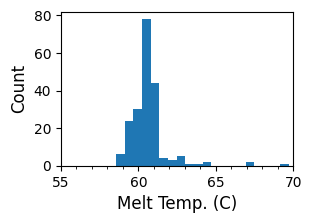

In [68]:
fig = plt.figure(figsize=(3, 2))
fig.set_dpi(100)
ax = fig.add_subplot(111)
mts = primer_df.Tm_NN
ax.hist(mts, bins=20)

ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Melt Temp. (C)', fontsize=12)

ax.set_xlim(55, 70)
ax.set_xticks(np.arange(55, 71, 1), minor=True)
plt.show()

## 3. Generate pooled oligo libraries using `library.generate_library()`

### Generate first library using best codon found for each position

In [79]:
kwargs = {'rank_to_select': 0,
          'keep_wt': False,
          'return_dfs': True,
          'mismatch_weight': 0.5,
          'usage_weight': 6}
# Generate a preselection_library_df, which contains a primer
# to change every WT codon to every other amino acid using
# every possible codon
#
# Then generate a library_df by selecting the codon from above
# with the highest combined codon usage + number of mismatches
# from WT. If possible, only mutagenesis codons that do not
# generate golden gate cut sites in the final sequences are used
#
# Writes the final library to a .csv with column "primer_new" containing
# the final selected oligos that can be pooled and used for saturating
# mutagenesis of the sequence at <input_path>
library_df0, preselection_library_df0 = library.generate_library(primer_df, **kwargs)

Finding alternative codons for primer number 0
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 0
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 1
Evaluating codons for amino acid F
Evalu

Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 48
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 49
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codo

Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 57
Found BsaI cut sit in primer
Found BsaI cut sit in primer
Found BsaI cut sit in primer
Found BsaI cut sit in primer
Found BsaI cut sit in primer
Found BsaI cut sit in primer
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 58
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codon

Finding alternative codons for primer number 67
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 67
Found BsmBI cut sit in primer
Found BsmBI cut sit in primer
Selected 20 primers for this site with rank 0
Finding alternative codon

Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 76
Found BsmBI cut sit in primer
Found BsmBI cut sit in primer
Found BsaI cut sit in primer
Found BsmBI cut sit in primer
Found BsaI cut sit in primer
Found BsmBI cut sit in primer
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 77
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating c

Finding alternative codons for primer number 86
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 86
Found BsaI cut sit in primer
Found BsaI cut sit in primer
Selected 20 primers for this site with rank 0
Finding alternative codons 

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 95
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 96
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon 

### Generate second library using second best codon found for each codon
This secondary library can be used as a technical replicate

In [80]:
kwargs = {'rank_to_select': 1,
          'keep_wt': False,
          'return_dfs': True,
          'mismatch_weight': 0.5,
          'usage_weight': 6}
second_library_df, second_preselection_library_df = library.generate_library(primer_df,
                                                                             **kwargs)

Finding alternative codons for primer number 0
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 0
Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 1
Evaluating codons for amino acid F
Evalu

Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 37
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 37
Selected 20 primers for this site with rank 1
Finding alternative codons for primer n

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 46
Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 47
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codo

Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 56
Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 57
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codo

Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 65
Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 66
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codo

Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 74
Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 75
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codo

Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 84
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 84
Selected 20 primers for this site with rank 1
Finding alternative codons for primer n


Evaluated codons of 20 amino acids for primer number 92
Selected 20 primers for this site with rank 1
Finding alternative codons for primer number 93
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 93
Selected 20 primers for this

# Appendix
Demonstration of how weights were set when choosing codons to optimize for maximum number of mismatches from the WT codon and highest codon usage

## Scan mismatch and usage weights

In [8]:
usage_weights = [0, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9]

library_dfs = []
for weight in usage_weights:
    print(f'Making library with codon usage weight {weight}')
    kwargs = {'rank_to_select': 0,
              'keep_wt': False,
              'return_dfs': True,
              'mismatch_weight': 0.5,
              'usage_weight': weight}

    library_df, preselection_df = library.generate_library(primer_df, **kwargs)
    library_dfs.append(library_df)

alldf = pd.concat(library_dfs, ignore_index=True)
combined_weights = alldf['mismatch_weight'].astype(str) + '-' + alldf['codon_usage_weight'].astype(str)
alldf.loc[:, 'mismatch_weight-usage_weight'] = combined_weights

Making library with codon usage weight 0
Finding alternative codons for primer number 0
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 0
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 1

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 18
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 19
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codo

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 27
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 28
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codo

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 37
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 38
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codo

Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 47
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 48
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codo

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 57
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 57
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 66
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 67
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon 

Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 75
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 76
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codo

Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 85
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 86
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codo

Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 94
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 95
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codo

Finding alternative codons for primer number 104
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 104
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 105
Evaluating codons for amino acid F

Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 113
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 114
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating co

Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 122
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 123
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codo

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 131
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 132
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated co

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 141
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 141
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 150
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 151
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating co

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 159
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 160
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating co

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 168
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 169
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating co

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 178
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 178
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 187
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 188
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating co

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 196
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 197
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating co

Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 4
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 5
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons

Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 13
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 14
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codo

Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 23
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 24
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codo

Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 32
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 33
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codo

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 42
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 42
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n

Finding alternative codons for primer number 51
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 51
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 52
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 60
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 61
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons 

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 69
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 70
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codo

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 79
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 80
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codo

Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 88
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 89
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon 

Finding alternative codons for primer number 98
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 98
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 99
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 107
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 108
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating co

Finding alternative codons for primer number 116
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 116
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 117
Evaluating codons for amino acid F

Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 125
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 126
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating co

Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 134
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 135
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating co

Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 143
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 144
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codon

Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 152
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 153
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer n

Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 162
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 163
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating co

Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 171
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 172
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating co

Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 180
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 181
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer n

Finding alternative codons for primer number 190
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 190
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 191
Evaluating codons for amino acid F

Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 199
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 200
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codo

Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 7
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 8
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 17
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 18
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codo

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 26
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 27
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codo

Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 36
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 37
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codo


Evaluated codons of 20 amino acids for primer number 45
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 46
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 46
Selected 20 primers for this

Finding alternative codons for primer number 55
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 55
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 56
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 65
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 65
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 66
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 74
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 75
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codo

Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 83
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 84
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons 

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 92
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 93
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codo

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 102
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 103
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating co


Evaluated codons of 20 amino acids for primer number 111
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 112
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 112
Selected 20 primers for t

Finding alternative codons for primer number 121
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 121
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 122
Evaluating codons for amino acid F

Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 130
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 131
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codo

Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 139
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 140
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer n

Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 149
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 150
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating co

Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 159
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 160
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating co


Evaluated codons of 20 amino acids for primer number 168
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 169
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 169
Selected 20 primers for t

Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 178
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 179
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating co

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 187
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 188
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating co

Finding alternative codons for primer number 197
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 197
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 198
Evaluating codons for amino acid F

Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 4
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 5
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons

Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 14
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 15
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons 

Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 23
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 24
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codo

Finding alternative codons for primer number 33
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 33
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 34
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 42
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 42
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 43
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 51
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 52
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codo


Evaluated codons of 20 amino acids for primer number 60
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 61
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 61
Selected 20 primers for this

Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 70
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 71
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons 

Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 79
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 80
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codo

Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 89
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 90
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codo

Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 98
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 99
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codo

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 108
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 108
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 117
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 118
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated co

Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 127
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 128
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating co

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 136
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 137
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating co

Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 145
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 146
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codon

Finding alternative codons for primer number 155
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 155
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 156
Evaluating codons for amino acid F

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 164
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 164
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 173
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 174
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating co

Finding alternative codons for primer number 183
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 183
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 184
Evaluating codons for amino acid F

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 192
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 192
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Dropping codons for WT amino acids
Saved primer library at C:\Users\John Cooper\Dropbox\Projects\spikedisplay\RBD_rank-0_usage-weight-4_mismatch-weight-0.5_oligo_library_no-WT_1628707850.387725.csv
Making library with codon usage weight 5
Finding alternative codons for primer number 0
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons fo

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 9
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 9
Selected 20 primers for this site with rank 0
Finding alternative codons for primer num

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 18
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 19
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codo

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 28
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 29
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon 

Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 37
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 38
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons 

Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 47
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 48
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codo

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 57
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 57
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n

Finding alternative codons for primer number 66
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 66
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 67
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 76
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 76
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 77
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 85
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 86
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codo

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 95
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 95
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n


Evaluated codons of 20 amino acids for primer number 104
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 105
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 105
Selected 20 primers for t

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 114
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 115
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated co

Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 124
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 125
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating co

Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 134
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 135
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating co

Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 144
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 145
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating co

Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 154
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 155
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating co

Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 163
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 164
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codo


Evaluated codons of 20 amino acids for primer number 172
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 173
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 173
Selected 20 primers for t

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 182
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 182
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Finding alternative codons for primer number 191
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 191
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 192
Evaluating codons for amino acid F

Finding alternative codons for primer number 200
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 200
Selected 20 primers for this site with rank 0
Dropping codons for WT amino acids
Saved primer library at C:\Users\John Cooper\Dro

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 8
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 8
Selected 20 primers for this site with rank 0
Finding alternative codons for primer num

Finding alternative codons for primer number 17
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 17
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 18
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 26
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 26
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 27
Evaluating codons for amino acid F
Ev

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 36
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 36
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 45
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 45
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 54
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 54
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 63
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 63
Selected 20 primers for this site with rank 0
Finding alternative codons for primer n

Finding alternative codons for primer number 72
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 72
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 73
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 81
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 82
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codo

Finding alternative codons for primer number 91
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 91
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 92
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 101
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 101
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 102
Evaluating codons for amino acid F

Finding alternative codons for primer number 110
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 110
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 111
Evaluating codons for amino acid F

Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 119
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 120
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codo

Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 128
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 129
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer n

Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 138
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 139
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating co

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 147
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 148
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating co

Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 156
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 157
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating co

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 166
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 166
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 175
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 176
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating co

Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 184
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 185
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer n

Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 194
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 195
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating co

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 2
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 2
Selected 20 primers for this site with rank 0
Finding alternative codons for primer num

Finding alternative codons for primer number 11
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 11
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 12
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 21
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 21
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 22
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 30
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 31
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons 

Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 39
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 40
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codo

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 49
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 50
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon 

Finding alternative codons for primer number 59
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 59
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 60
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 68
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 68
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 69
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 77
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 78
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codo

Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 87
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 88
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codo

Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 96
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 97
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon 

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 114
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 115
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating co

Finding alternative codons for primer number 124
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 124
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 125
Evaluating codons for amino acid F

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 133
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 134
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated co

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 142
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 143
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating co

Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 152
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 153
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating co

Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 161
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 162
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated co

Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 171
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 172
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating co

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 180
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 181
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating co

Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 189
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 190
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating co

Finding alternative codons for primer number 199
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 199
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 200
Evaluating codons for amino acid F

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 7
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 7
Selected 20 primers for this site with rank 0
Finding alternative codons for primer num

Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 16
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 17
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer num

Finding alternative codons for primer number 26
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 26
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 27
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 35
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 35
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 36
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 44
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 44
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 45
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 53
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 53
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 54
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 62
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 62
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 63
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 71
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 72
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon 

Finding alternative codons for primer number 81
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 81
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 82
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 90
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 91
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codo

Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 100
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 101
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating co

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 109
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 110
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating co

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 119
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 119
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 128
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 128
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 137
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 138
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating co

Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 146
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 147
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating co

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 156
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 156
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 165
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 166
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codo

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 175
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 175
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 184
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 185
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating co

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 193
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 194
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codo

Finding alternative codons for primer number 1
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 1
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 2
Evaluating codons for amino acid F
Evalu

Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 10
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 11
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codo


Evaluated codons of 20 amino acids for primer number 19
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 20
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 20
Selected 20 primers for this

Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 29
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 30
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codo

Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 38
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 39
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codo

Finding alternative codons for primer number 48
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 48
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 49
Evaluating codons for amino acid F
Ev

Finding alternative codons for primer number 57
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 57
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 58
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 66
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 67
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codo

Finding alternative codons for primer number 76
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 76
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 77
Evaluating codons for amino acid F
Ev

Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 85
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 86
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codo

Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 94
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 95
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons 

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 104
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 104
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Finding alternative codons for primer number 113
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 113
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 114
Evaluating codons for amino acid F

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 122
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 122
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 131
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 131
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 140
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 140
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 149
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 149
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 158
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 158
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 167
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 168
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codo

Finding alternative codons for primer number 177
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 177
Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 178
Evaluating codons for amino acid F

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 186
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 186
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

Selected 20 primers for this site with rank 0
Finding alternative codons for primer number 195
Evaluating codons for amino acid F
Evaluating codons for amino acid L
Evaluating codons for amino acid Y
Evaluating codons for amino acid H
Evaluating codons for amino acid Q
Evaluating codons for amino acid I
Evaluating codons for amino acid M
Only one codon for amino acid M
Evaluating codons for amino acid N
Evaluating codons for amino acid K
Evaluating codons for amino acid V
Evaluating codons for amino acid D
Evaluating codons for amino acid E
Evaluating codons for amino acid S
Evaluating codons for amino acid C
Evaluating codons for amino acid W
Only one codon for amino acid W
Evaluating codons for amino acid P
Evaluating codons for amino acid R
Evaluating codons for amino acid T
Evaluating codons for amino acid A
Evaluating codons for amino acid G

Evaluated codons of 20 amino acids for primer number 195
Selected 20 primers for this site with rank 0
Finding alternative codons for primer

### Plot codon usage, # mismatches from WT, and primer melt temps across varying codon usage and mismatch weight

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


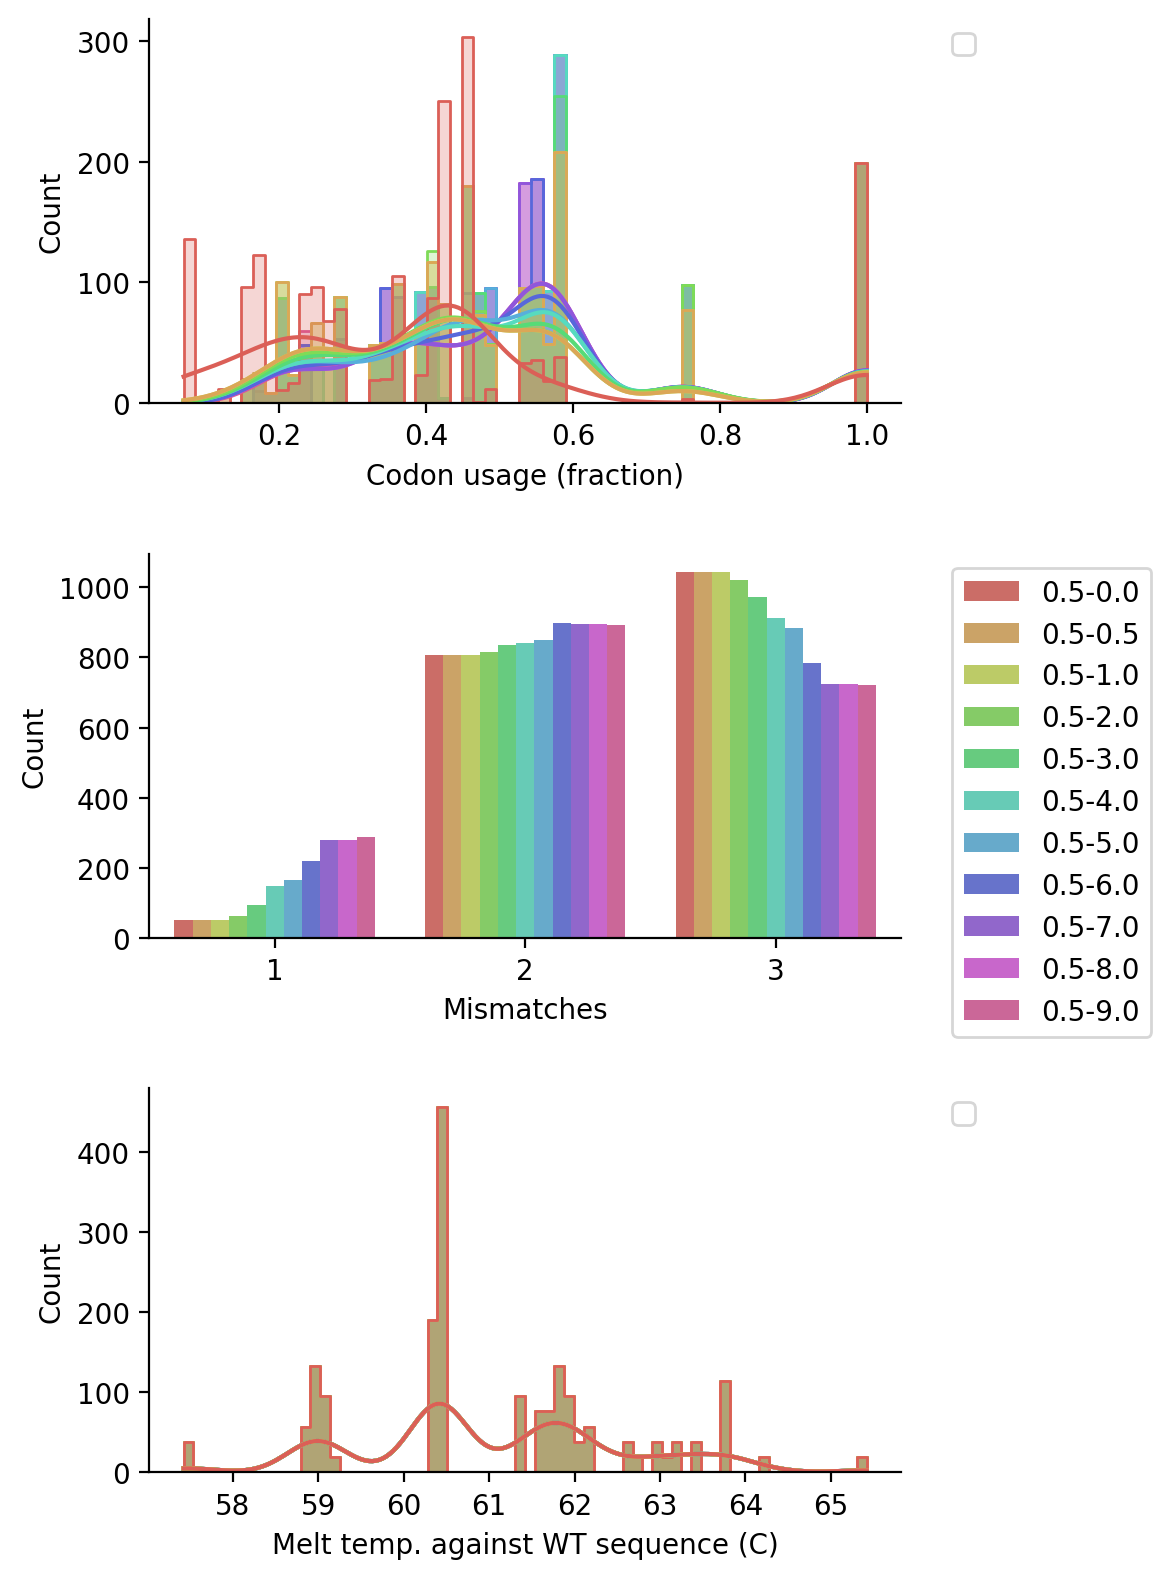

In [11]:
fig = plt.figure(figsize=(6, 8))
fig.set_dpi(200)

n_colors = len(alldf['mismatch_weight-usage_weight'].unique())
palette = sns.color_palette('hls', n_colors)

histkwargs = {'hue': 'mismatch_weight-usage_weight',
              'data': alldf,
              'element': 'step',
              'kde': True,
              'palette': palette}

countkwargs = {'hue': 'mismatch_weight-usage_weight',
              'data': alldf,
              'palette': palette}

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
xlabels = ['Codon usage (fraction)',
           'Mismatches',
           'Melt temp. against WT sequence (C)']
axs = [ax1, ax2, ax3]
# Plot codon usage
sns.histplot(x='fraction', **histkwargs, ax=ax1)
# Plot mismatches
sns.countplot(x='levenshtein_dist', **countkwargs, ax=ax2)
# Plot melt temp
sns.histplot(x='Tm_real', **histkwargs, ax=ax3)


for i, ax in enumerate(axs):
    ax.set_xlabel(xlabels[i])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylabel('Count')
    for n in ['top', 'right']:
        ax.spines[n].set_visible(False)
plt.tight_layout()

## Plot median codon usage and number of mismatches from WT per primer vs. codon usage weight while holding mismatch weight constant

Text(0.5, 0, 'Codon usage weight (mismatch weight 0.5)')

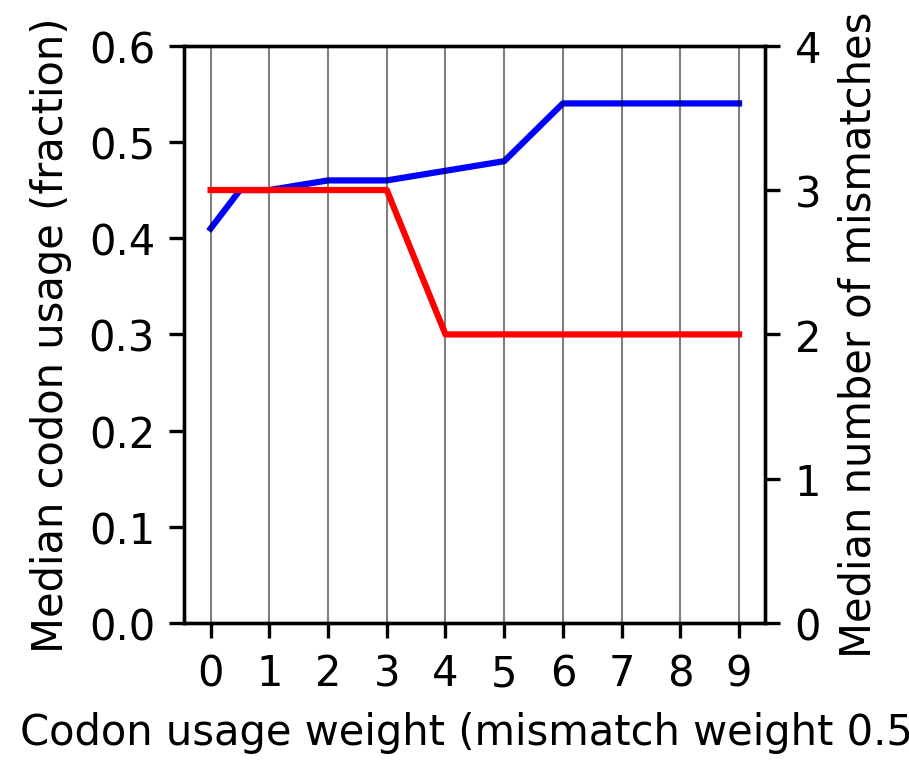

In [48]:
# Fix data types
alldf['fraction'] = alldf.fraction.astype(float)
# Only aggregate on columns with non-string columns
cols = [col for col in alldf.columns if alldf[col].dtype !='O']
# Include the column used for aggregation in above list
aggdex = ['mismatch_weight-usage_weight']
cols = cols + [col for col in aggdex if col not in cols]
table = alldf.loc[:, cols].pivot_table(index=aggdex, aggfunc='median')
table.reset_index(inplace=True)

fig = plt.figure(figsize=(2.5, 2.5))
fig.set_dpi(300)
ax = fig.add_subplot(111)

ax.plot(table.codon_usage_weight, table.fraction, color='blue')
ax.set_ylim(0, 0.6)
ax.set_xticks(np.arange(0, 10, 1))

for t in ax.get_xticks():
    ax.axvline(t, color='black', linewidth='0.5', alpha=0.5)

ax2 = ax.twinx()
ax2.set_ylim(0, 4)
ax2.plot(table.codon_usage_weight, table.levenshtein_dist, color='red')

ax.set_ylabel('Median codon usage (fraction)')
ax2.set_ylabel('Median number of mismatches')
ax.set_xlabel('Codon usage weight (mismatch weight 0.5)')

## Other library summaries

### Melt temps of pre-selection pooled library

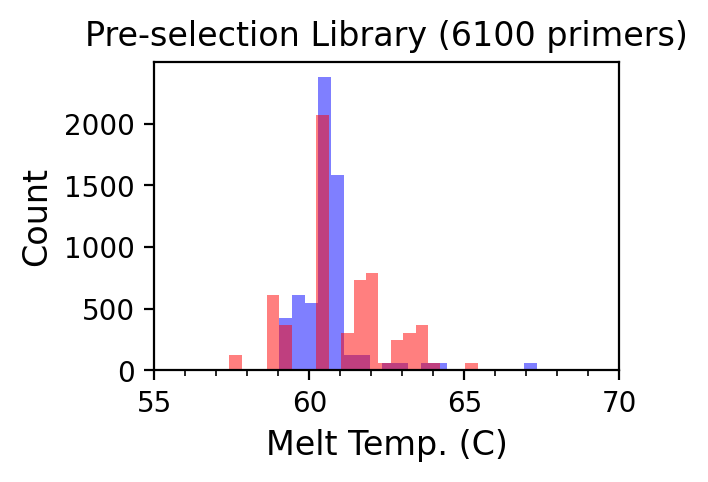

In [49]:
fig = plt.figure(figsize=(3, 2))
fig.set_dpi(200)
ax = fig.add_subplot(111)
yvar = 'primer_Tm_NN'
yvar2 = 'Tm_real'
y = preselection_library_df0.loc[:, yvar]
y2 = preselection_library_df0.loc[:, yvar2]
ax.hist(y, bins=20, color='blue', alpha=0.5)
ax.hist(y2, bins=20, color='red', alpha=0.5)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Melt Temp. (C)', fontsize=12)

ax.set_xlim(55, 70)
ax.set_xticks(np.arange(55, 71, 1), minor=True)
ax.set_title(f'Pre-selection Library ({len(y)} primers)')
plt.show()

### Melt temps of primer library selected for highest codon usage and # of mismatches from WT

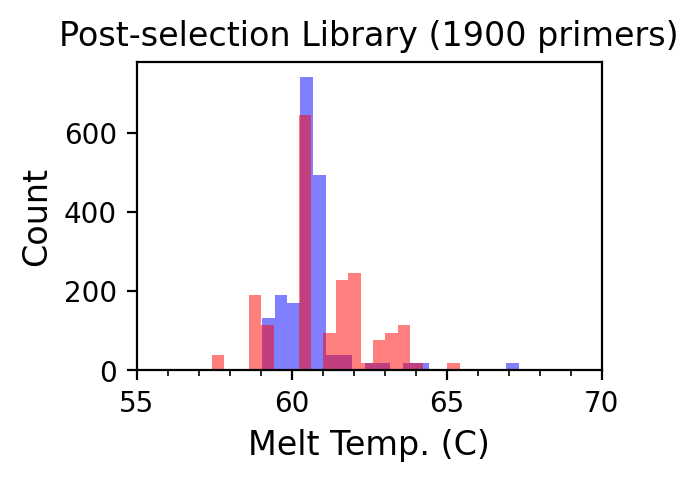

In [50]:
fig = plt.figure(figsize=(3, 2))
fig.set_dpi(200)
ax = fig.add_subplot(111)
yvar = 'primer_Tm_NN'
yvar2 = 'Tm_real'
y = library_df0.loc[:, yvar]
y2 = library_df0.loc[:, yvar2]
ax.hist(y, bins=20, color='blue', alpha=0.5)
ax.hist(y2, bins=20, color='red', alpha=0.5)
ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Melt Temp. (C)', fontsize=12)

ax.set_xlim(55, 70)
ax.set_xticks(np.arange(55, 71, 1), minor=True)
ax.set_title(f'Post-selection Library ({len(y)} primers)')
plt.show()